# Stage 2.1 — EDA time-series

This notebook builds time-series views over `df_all`, `df_strict`, and `df_sleep` using matplotlib only.

Set SAVE_FIGS=True to export all figures to reports/figures/timeseries (local, gitignored).

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from garmin_analytics.eda import prepare as eda_prepare

SAVE_FIGS: bool = False
FIG_DIR = Path("reports/figures/timeseries")
DPI = 150
FIG_FMT = "png"

add_derived_features = eda_prepare.add_derived_features
build_eda_frames = eda_prepare.build_eda_frames
load_daily_sanitized = eda_prepare.load_daily_sanitized
load_quality = eda_prepare.load_quality

pd.set_option('display.max_columns', 120)

In [2]:
repo_root = Path.cwd() / '..'
daily_sanitized_path = repo_root / 'data/processed/daily_sanitized.parquet'
daily_fallback_path = repo_root / 'data/processed/daily.parquet'
quality_path = repo_root / 'data/processed/daily_quality.parquet'

daily_path = daily_sanitized_path if daily_sanitized_path.exists() else daily_fallback_path
if not daily_path.exists():
    raise FileNotFoundError(f'Daily parquet not found: {daily_path}')
if not quality_path.exists():
    raise FileNotFoundError(f'Quality parquet not found: {quality_path}')

daily_df = load_daily_sanitized(daily_path)
quality_df = load_quality(quality_path)

frames = build_eda_frames(daily_df, quality_df, strict_min_score=4, loose_min_score=3)
df_all = add_derived_features(frames['df_all'])
df_strict = add_derived_features(frames['df_strict'])
df_sleep = add_derived_features(frames['df_sleep'])

# Explicit Stage 2.1 filters (same logic, re-applied for clarity)
for req_col in ['valid_day_strict', 'corrupted_stress_only_day', 'has_sleep']:
    if req_col not in df_all.columns:
        raise KeyError(f'Missing required quality column: {req_col}')

df_strict = df_all[(df_all['valid_day_strict'] == True) & (df_all['corrupted_stress_only_day'] == False)].copy()
df_sleep = df_all[(df_all['has_sleep'] == True) & (df_all['corrupted_stress_only_day'] == False)].copy()

for _df in [df_all, df_strict, df_sleep]:
    _df.sort_values('calendarDate', inplace=True)

print('Daily input:', daily_path)
print('Quality input:', quality_path)

Daily input: /Users/abatrakov/Documents/FUN/wearable-analytics/notebooks/../data/processed/daily_sanitized.parquet
Quality input: /Users/abatrakov/Documents/FUN/wearable-analytics/notebooks/../data/processed/daily_quality.parquet


In [3]:
summary_rows = []
for name, frame in [('df_all', df_all), ('df_strict', df_strict), ('df_sleep', df_sleep)]:
    summary_rows.append({
        'slice': name,
        'rows': len(frame),
        'date_min': frame['calendarDate'].min(),
        'date_max': frame['calendarDate'].max(),
    })

timeseries_summary = pd.DataFrame(summary_rows)
timeseries_summary

,slice,rows,date_min,date_max
0,df_all,580,2023-05-26,2026-02-05
1,df_strict,525,2023-05-26,2026-02-05
2,df_sleep,474,2023-05-27,2026-02-05


In [ ]:
def maybe_save(fig, name: str):
    """
    Save a matplotlib figure to FIG_DIR if SAVE_FIGS is True.
    Name should be a short slug (no spaces). The function creates FIG_DIR.
    """
    if not SAVE_FIGS:
        return
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(FIG_DIR / f"{name}.{FIG_FMT}", dpi=DPI, bbox_inches="tight")

def _find_col(frame: pd.DataFrame, preferred: str, fallback: str | None = None) -> str | None:
    if preferred in frame.columns:
        return preferred
    if fallback is not None and fallback in frame.columns:
        return fallback
    return None

def _plot_line_with_roll(
    frame: pd.DataFrame,
    y_col: str,
    title: str,
    ylabel: str,
    rolling_window: int = 7,
    save_name: str | None = None,
 ) -> None:
    if y_col not in frame.columns:
        print(f'Skip: missing column {y_col}')
        return
    plot_df = frame[['calendarDate', y_col]].copy()
    plot_df[y_col] = pd.to_numeric(plot_df[y_col], errors='coerce')
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(plot_df['calendarDate'], plot_df[y_col], label=y_col)
    roll = plot_df[y_col].rolling(rolling_window, min_periods=1).mean()
    ax.plot(plot_df['calendarDate'], roll, label=f'{rolling_window}-day mean')
    ax.set_title(title)
    ax.set_xlabel('calendarDate')
    ax.set_ylabel(ylabel)
    ax.legend()
    fig.tight_layout()
    if save_name is not None:
        maybe_save(fig, save_name)
    plt.show()

## Quality

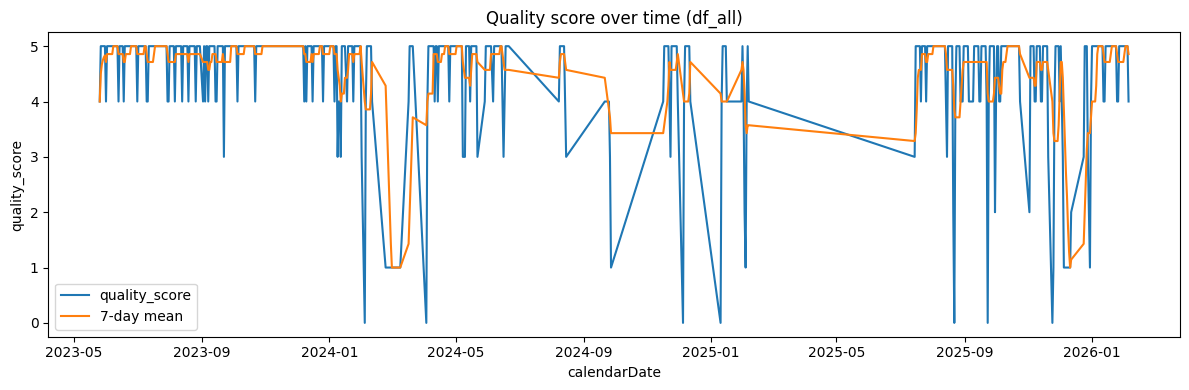

In [ ]:
_plot_line_with_roll(df_all, 'quality_score', 'Quality score over time (df_all)', 'quality_score', save_name='quality_score')

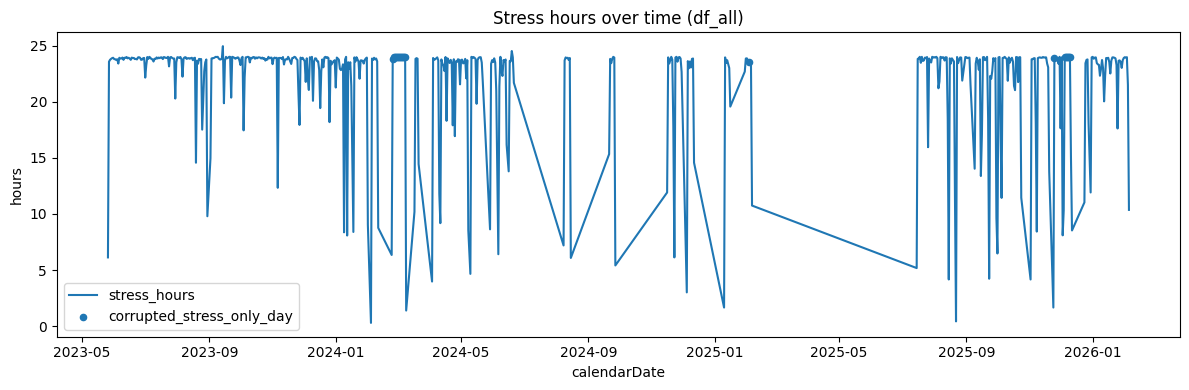

In [ ]:
if 'stress_hours' not in df_all.columns:
    print('Skip: missing column stress_hours')
else:
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(df_all['calendarDate'], pd.to_numeric(df_all['stress_hours'], errors='coerce'), label='stress_hours')

    if 'corrupted_stress_only_day' in df_all.columns:
        mask = df_all['corrupted_stress_only_day'].fillna(False).astype(bool)
        if mask.any():
            ax.scatter(
                df_all.loc[mask, 'calendarDate'],
                pd.to_numeric(df_all.loc[mask, 'stress_hours'], errors='coerce'),
                label='corrupted_stress_only_day',
                s=20,
            )

    ax.set_title('Stress hours over time (df_all)')
    ax.set_xlabel('calendarDate')
    ax.set_ylabel('hours')
    ax.legend()
    fig.tight_layout()
    maybe_save(fig, 'stress_hours_all')
    plt.show()

## Activity

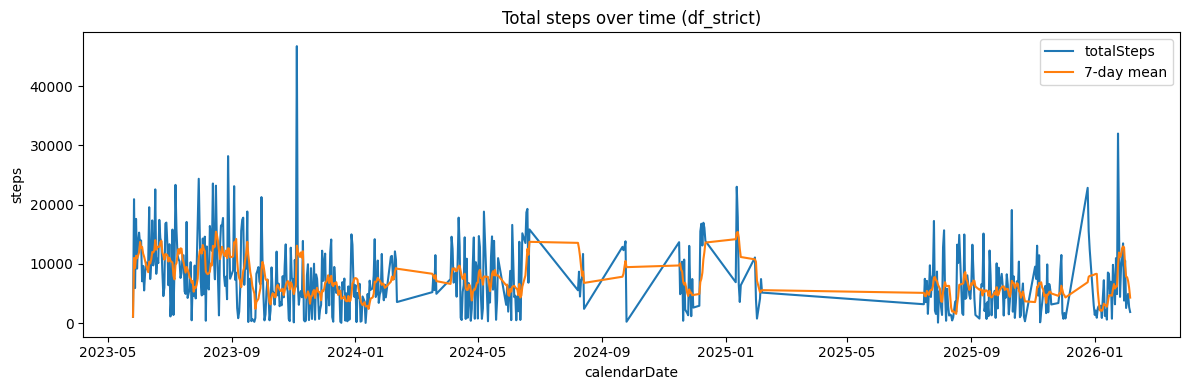

In [ ]:
_plot_line_with_roll(df_strict, 'totalSteps', 'Total steps over time (df_strict)', 'steps', save_name='steps_strict')

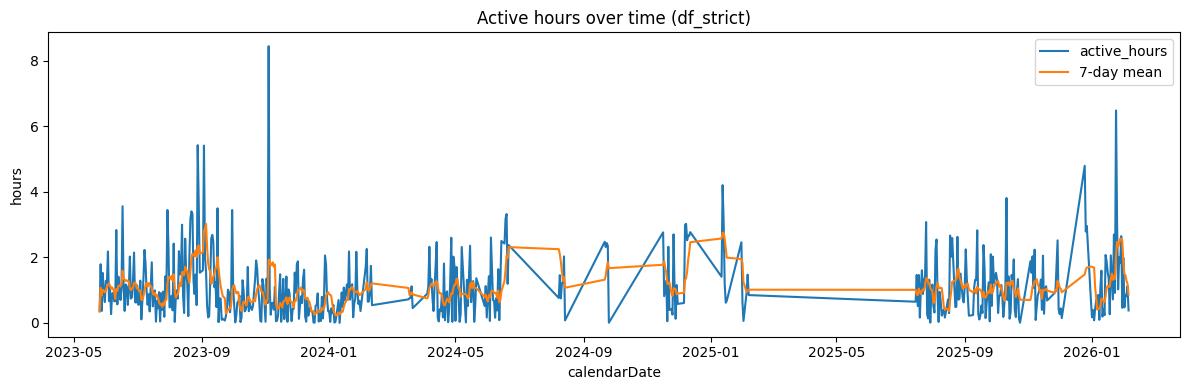

In [ ]:
if 'activeSeconds' in df_strict.columns:
    tmp = df_strict[['calendarDate', 'activeSeconds']].copy()
    tmp['active_hours'] = pd.to_numeric(tmp['activeSeconds'], errors='coerce') / 3600.0
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(tmp['calendarDate'], tmp['active_hours'], label='active_hours')
    ax.plot(tmp['calendarDate'], tmp['active_hours'].rolling(7, min_periods=1).mean(), label='7-day mean')
    ax.set_title('Active hours over time (df_strict)')
    ax.set_xlabel('calendarDate')
    ax.set_ylabel('hours')
    ax.legend()
    fig.tight_layout()
    maybe_save(fig, 'active_hours_strict')
    plt.show()
else:
    print('Skip: missing column activeSeconds')

## Stress

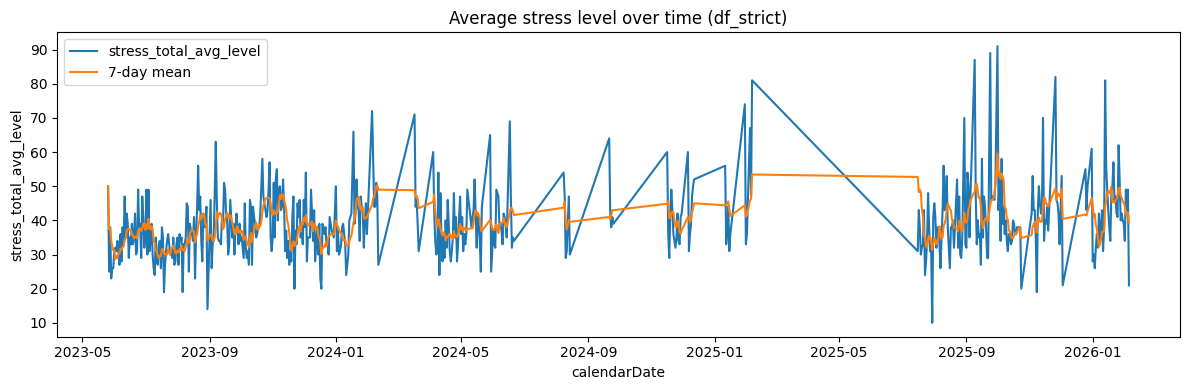

In [ ]:
stress_avg_col = _find_col(df_strict, 'stress_total_avg_level', 'allDayStress_TOTAL_averageStressLevel')
if stress_avg_col is None:
    print('Skip: missing stress average level column')
else:
    _plot_line_with_roll(
        df_strict,
        stress_avg_col,
        'Average stress level over time (df_strict)',
        stress_avg_col,
        rolling_window=7,
        save_name='stress_avg_level_strict',
    )

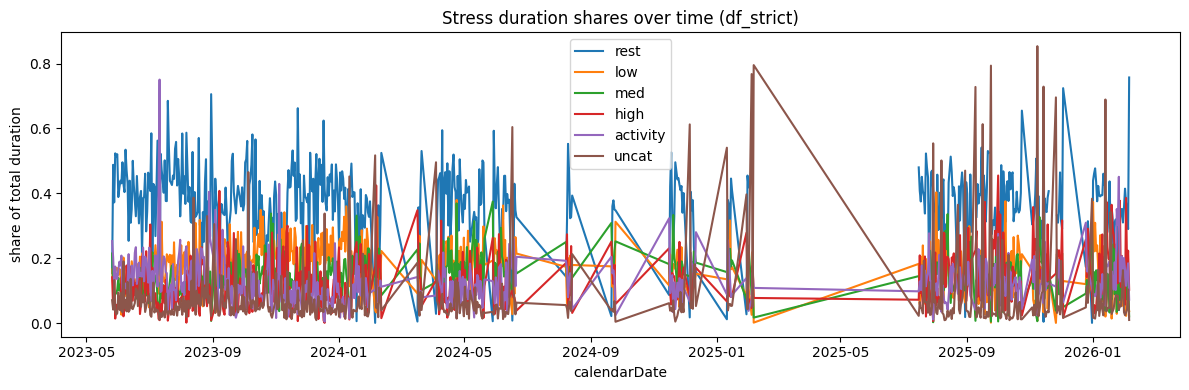

In [ ]:
dur_candidates = {
    'rest': _find_col(df_strict, 'stress_total_rest_s', 'allDayStress_TOTAL_restDuration'),
    'low': _find_col(df_strict, 'stress_total_low_s', 'allDayStress_TOTAL_lowDuration'),
    'med': _find_col(df_strict, 'stress_total_med_s', 'allDayStress_TOTAL_mediumDuration'),
    'high': _find_col(df_strict, 'stress_total_high_s', 'allDayStress_TOTAL_highDuration'),
    'activity': _find_col(df_strict, 'stress_total_activity_s', 'allDayStress_TOTAL_activityDuration'),
    'uncat': _find_col(df_strict, 'stress_total_uncat_s', 'allDayStress_TOTAL_uncategorizedDuration'),
}
total_col = _find_col(df_strict, 'stress_total_total_duration_s', 'allDayStress_TOTAL_totalDuration')

if total_col is None or any(v is None for v in dur_candidates.values()):
    print('Skip: missing one or more stress duration columns for share plot')
else:
    stress_df = df_strict[['calendarDate', total_col, *dur_candidates.values()]].copy()
    for col in [total_col, *dur_candidates.values()]:
        stress_df[col] = pd.to_numeric(stress_df[col], errors='coerce')

    total = stress_df[total_col].where(stress_df[total_col] > 0)

    fig, ax = plt.subplots(figsize=(12, 4))
    for label, col in dur_candidates.items():
        share = stress_df[col] / total
        ax.plot(stress_df['calendarDate'], share, label=label)

    ax.set_title('Stress duration shares over time (df_strict)')
    ax.set_xlabel('calendarDate')
    ax.set_ylabel('share of total duration')
    ax.legend()
    fig.tight_layout()
    maybe_save(fig, 'stress_breakdown_shares_strict')
    plt.show()

## Heart

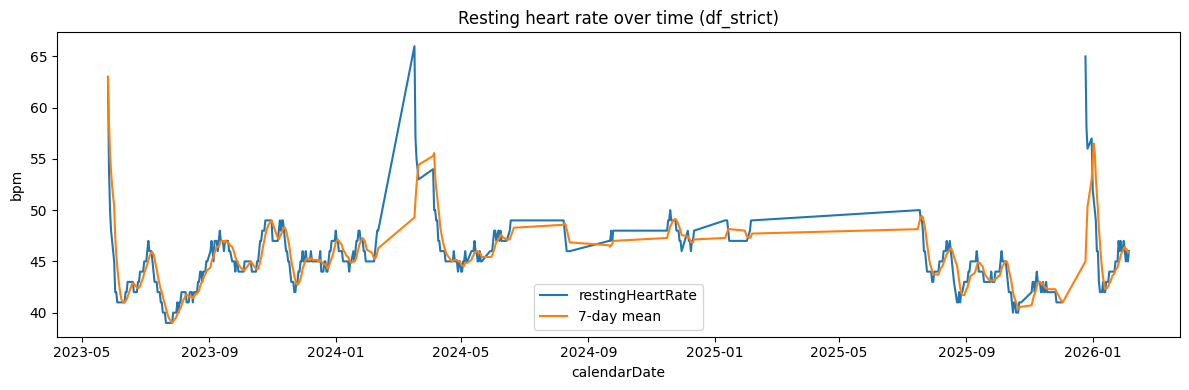

In [ ]:
_plot_line_with_roll(df_strict, 'restingHeartRate', 'Resting heart rate over time (df_strict)', 'bpm', save_name='resting_hr_strict')

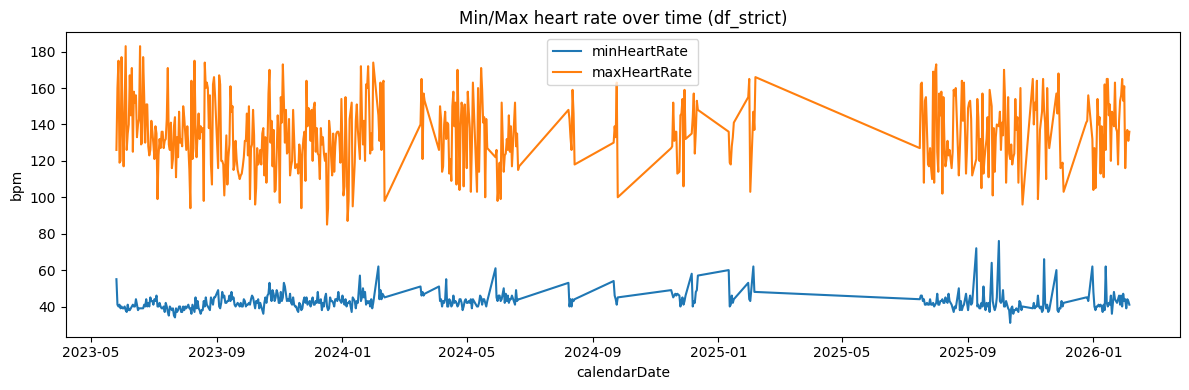

In [ ]:
needed = ['minHeartRate', 'maxHeartRate']
if not all(c in df_strict.columns for c in needed):
    print('Skip: missing minHeartRate or maxHeartRate')
else:
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(df_strict['calendarDate'], pd.to_numeric(df_strict['minHeartRate'], errors='coerce'), label='minHeartRate')
    ax.plot(df_strict['calendarDate'], pd.to_numeric(df_strict['maxHeartRate'], errors='coerce'), label='maxHeartRate')
    ax.set_title('Min/Max heart rate over time (df_strict)')
    ax.set_xlabel('calendarDate')
    ax.set_ylabel('bpm')
    ax.legend()
    fig.tight_layout()
    maybe_save(fig, 'minmax_hr_strict')
    plt.show()

## BodyBattery

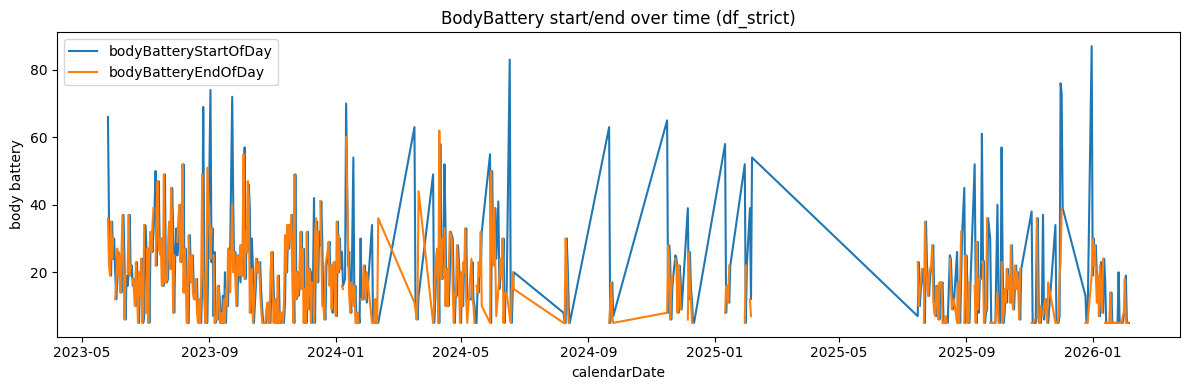

In [ ]:
needed = ['bodyBatteryStartOfDay', 'bodyBatteryEndOfDay']
if not all(c in df_strict.columns for c in needed):
    print('Skip: missing BodyBattery start/end columns')
else:
    bb_df = df_strict[['calendarDate', 'bodyBatteryStartOfDay', 'bodyBatteryEndOfDay']].copy()
    bb_df['bodyBatteryStartOfDay'] = pd.to_numeric(bb_df['bodyBatteryStartOfDay'], errors='coerce')
    bb_df['bodyBatteryEndOfDay'] = pd.to_numeric(bb_df['bodyBatteryEndOfDay'], errors='coerce')

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(bb_df['calendarDate'], bb_df['bodyBatteryStartOfDay'], label='bodyBatteryStartOfDay')
    ax.plot(bb_df['calendarDate'], bb_df['bodyBatteryEndOfDay'], label='bodyBatteryEndOfDay')
    ax.set_title('BodyBattery start/end over time (df_strict)')
    ax.set_xlabel('calendarDate')
    ax.set_ylabel('body battery')
    ax.legend()
    fig.tight_layout()
    maybe_save(fig, 'bodybattery_start_end_strict')
    plt.show()

    bb_df['bb_delta'] = bb_df['bodyBatteryEndOfDay'] - bb_df['bodyBatteryStartOfDay']
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(bb_df['calendarDate'], bb_df['bb_delta'], label='bb_delta')
    ax.plot(bb_df['calendarDate'], bb_df['bb_delta'].rolling(7, min_periods=1).mean(), label='7-day mean')
    ax.set_title('BodyBattery delta over time (df_strict)')
    ax.set_xlabel('calendarDate')
    ax.set_ylabel('delta')
    ax.legend()
    fig.tight_layout()
    maybe_save(fig, 'bb_delta_strict')
    plt.show()

## Sleep

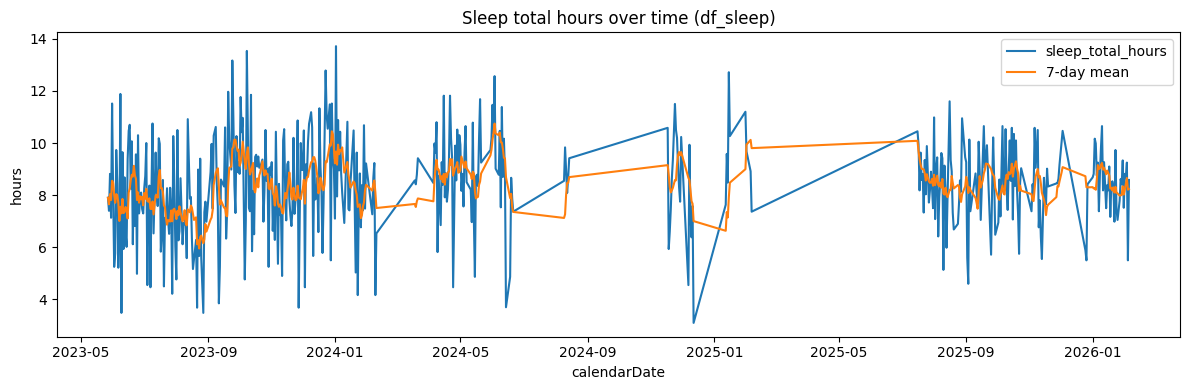

In [ ]:
_plot_line_with_roll(df_sleep, 'sleep_total_hours', 'Sleep total hours over time (df_sleep)', 'hours', save_name='sleep_total_hours')

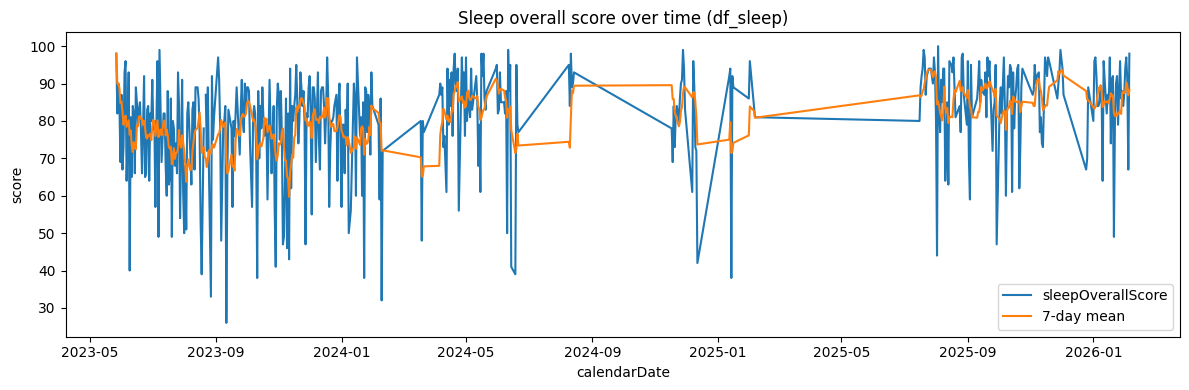

In [ ]:
_plot_line_with_roll(df_sleep, 'sleepOverallScore', 'Sleep overall score over time (df_sleep)', 'score', save_name='sleep_overall_score')

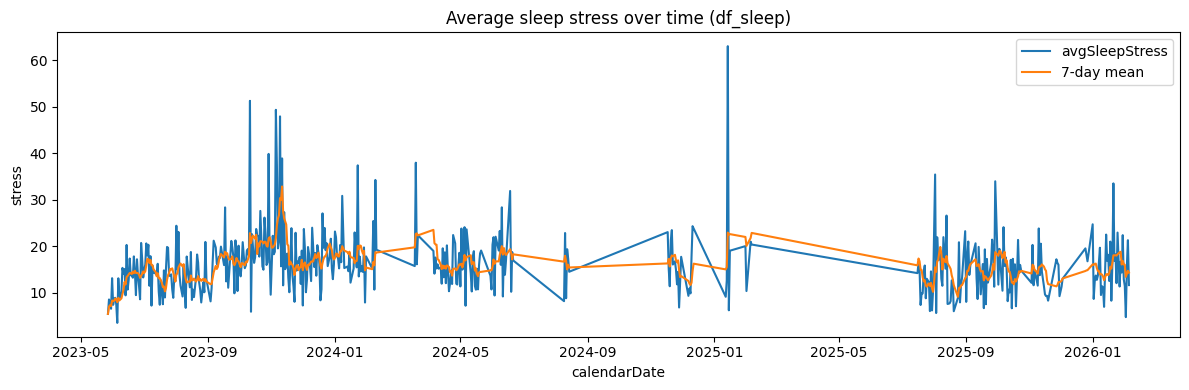

In [ ]:
if 'avgSleepStress' in df_sleep.columns:
    _plot_line_with_roll(
        df_sleep,
        'avgSleepStress',
        'Average sleep stress over time (df_sleep)',
        'stress',
        save_name='avg_sleep_stress',
    )
else:
    print('Skip: missing avgSleepStress')

## Optional local save (disabled)

The cell below shows how to save figures locally if needed (kept disabled by default).

In [19]:
# SAVE_FIGURES = False
# if SAVE_FIGURES:
#     out_dir = repo_root / 'reports/figures'
#     out_dir.mkdir(parents=True, exist_ok=True)
#     # plt.savefig(out_dir / 'example.png', dpi=150, bbox_inches='tight')
#     print('Figure output directory:', out_dir)